In [1]:
# EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# ML algorithms
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import shap

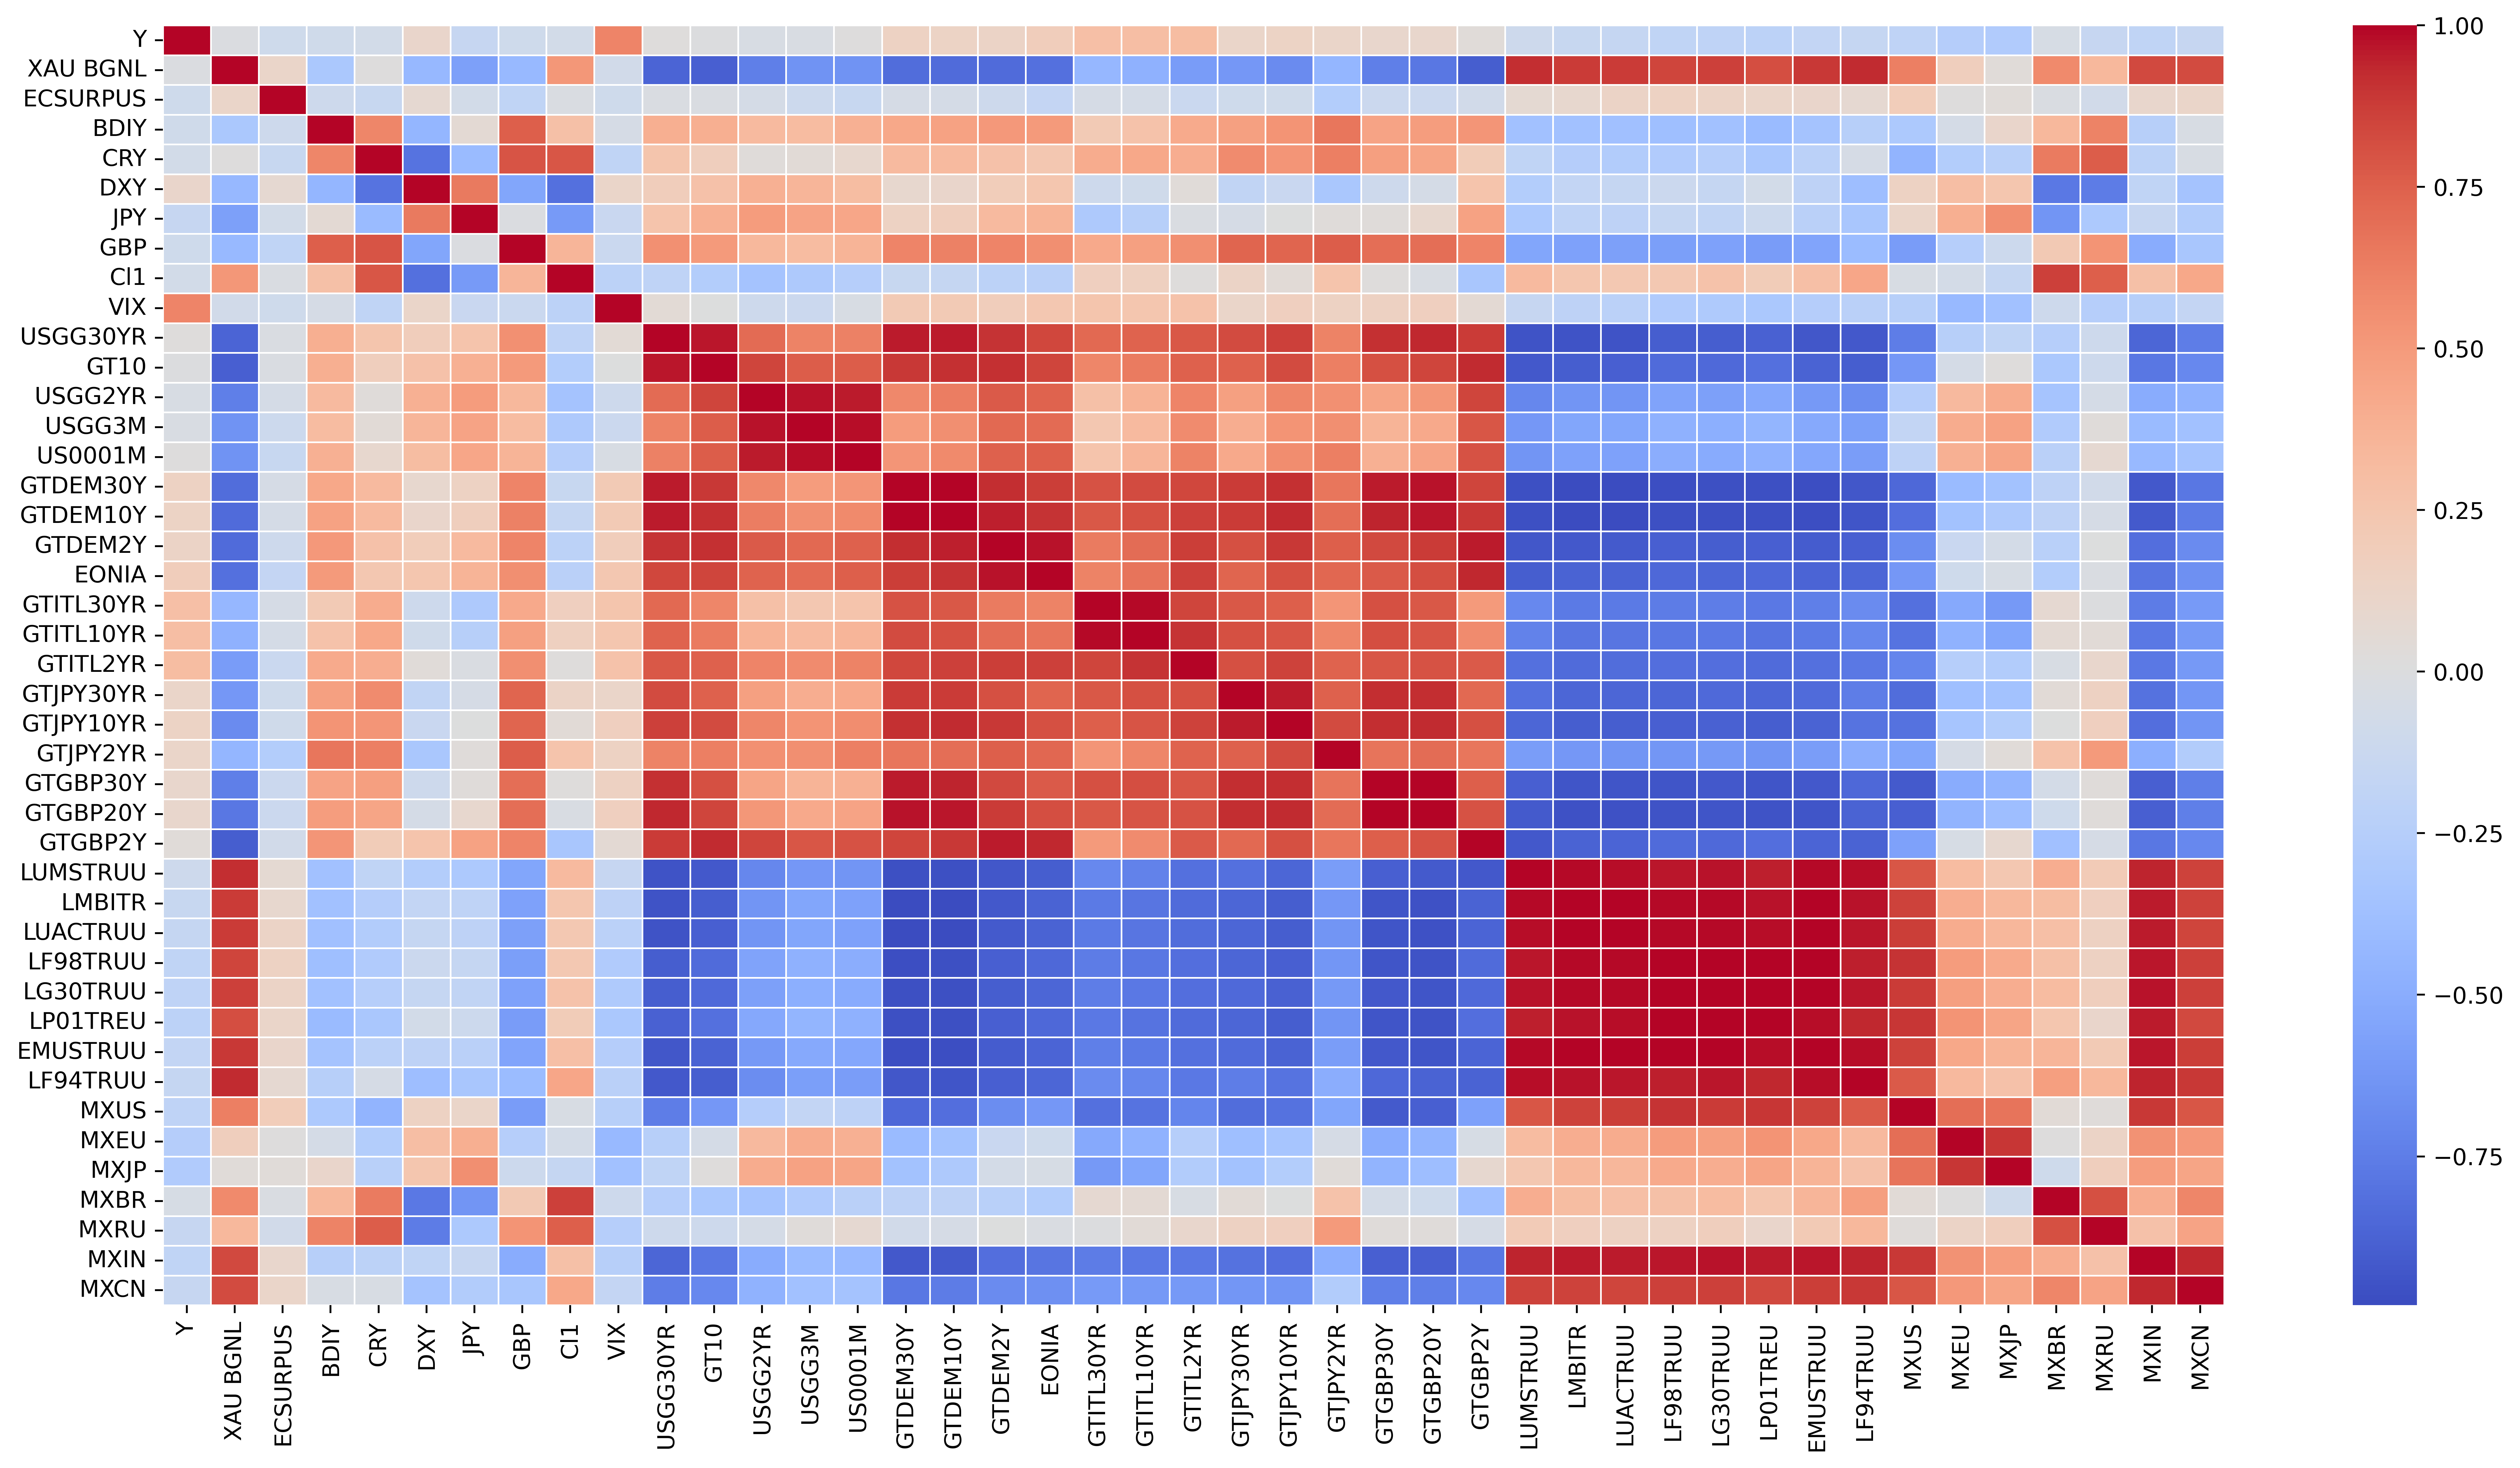

In [2]:
df = pd.read_csv("docs/data.csv")
numeric = df.select_dtypes(include=[np.number])
corr = numeric.corr()
plt.figure(figsize=(20,10), dpi =500)
sns.heatmap(corr, annot=False, linewidth=.5, cmap='coolwarm')
plt.show()

save = False
if save:
    plt.savefig('correlation_matrix.png')

In [3]:
# Select specified features and the target variable
features = df.drop(columns=['Y', 'Data'])  # Exclude target and timestamp columns
target = df['Y']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify=target)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train a logistic regression model
log_reg = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000, C=2)
log_reg.fit(X_train_scaled, y_train)

# Predict probabilities and classes for the training set
y_train_pred = log_reg.predict(X_train_scaled)
y_train_pred_prob = log_reg.predict_proba(X_train_scaled)[:, 1]

# Predict on the test set
y_pred = log_reg.predict(X_test_scaled)
y_pred_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# Evaluate the model
log_reg_report = classification_report(y_test, y_pred)
log_reg_roc_auc = roc_auc_score(y_test, y_pred_prob)
log_reg_conf_matrix = confusion_matrix(y_test, y_pred)

print(log_reg_roc_auc)
print(log_reg_report)
print(log_reg_conf_matrix)

0.9517857142857142
              precision    recall  f1-score   support

           0       0.97      0.85      0.91       175
           1       0.62      0.90      0.74        48

    accuracy                           0.86       223
   macro avg       0.80      0.87      0.82       223
weighted avg       0.89      0.86      0.87       223

[[149  26]
 [  5  43]]


In [4]:
# Add predictions for the training data
df.loc[X_train.index, 'Predicted_Prob'] = y_train_pred_prob
df.loc[X_train.index, 'Predicted_Class'] = y_train_pred

# Add predictions for the test data
df.loc[X_test.index, 'Predicted_Prob'] = y_pred_prob
df.loc[X_test.index, 'Predicted_Class'] = y_pred

# Define actions based on predictions
df['Action'] = df['Predicted_Prob'].apply(lambda x: 'Reduce Risk' if x > 0.5 else 'Invest More')